# ARIMA Model

### Add project path to system path

In [2]:
import os
notebook_dir = os.getcwd()
parent_path=os.path.dirname(notebook_dir)

os.chdir(parent_path)

### Load Data

In [7]:
import pandas as pd
brent_oil_price_data=pd.read_csv("data/brent_oil_price_data.csv")

In [8]:
brent_oil_price_data.head()

,Date,Price
0,1987-05-20,18.63
1,1987-05-21,18.45
2,1987-05-22,18.55
3,1987-05-25,18.60
4,1987-05-26,18.63


In [13]:
brent_oil_price_data['Date']= pd.to_datetime(brent_oil_price_data['Date']) 
brent_oil_price_data.set_index(brent_oil_price_data['Date'],inplace=True)
brent_oil_price_data.drop(columns='Date')


,Price
Date,
1987-05-20,18.63
1987-05-21,18.45
1987-05-22,18.55
1987-05-25,18.60
1987-05-26,18.63
...,...
2022-11-08,96.85
2022-11-09,93.05
2022-11-10,94.25


## Check Stationarity

In [15]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(time_series):
    adf_result = adfuller(time_series.dropna()) 
    
    result = {
        'ADF Statistic': adf_result[0],
        'p-value': adf_result[1],
        'Critical Values': adf_result[4],
        'Conclusion': 'Stationary' if adf_result[1] < 0.05 else 'Non-Stationary'
    }
    
    print("ADF Statistic:", result['ADF Statistic'])
    print("p-value:", result['p-value'])
    print("Critical Values:", result['Critical Values'])
    print("Conclusion:", result['Conclusion'])
    
    return result

result=check_stationarity(brent_oil_price_data['Price'])

ADF Statistic: -1.993856011392466
p-value: 0.2892735048934034
Critical Values: {'1%': -3.4310783342658615, '5%': -2.861861876398633, '10%': -2.566941329781918}
Conclusion: Non-Stationary


## First difference

In [16]:
import numpy as np
first_diff=brent_oil_price_data.Price.values[1:]-brent_oil_price_data.Price.values[:-1]
first_diff=np.concatenate([first_diff,[0]])

In [17]:
brent_oil_price_data['FirstDifference']=first_diff

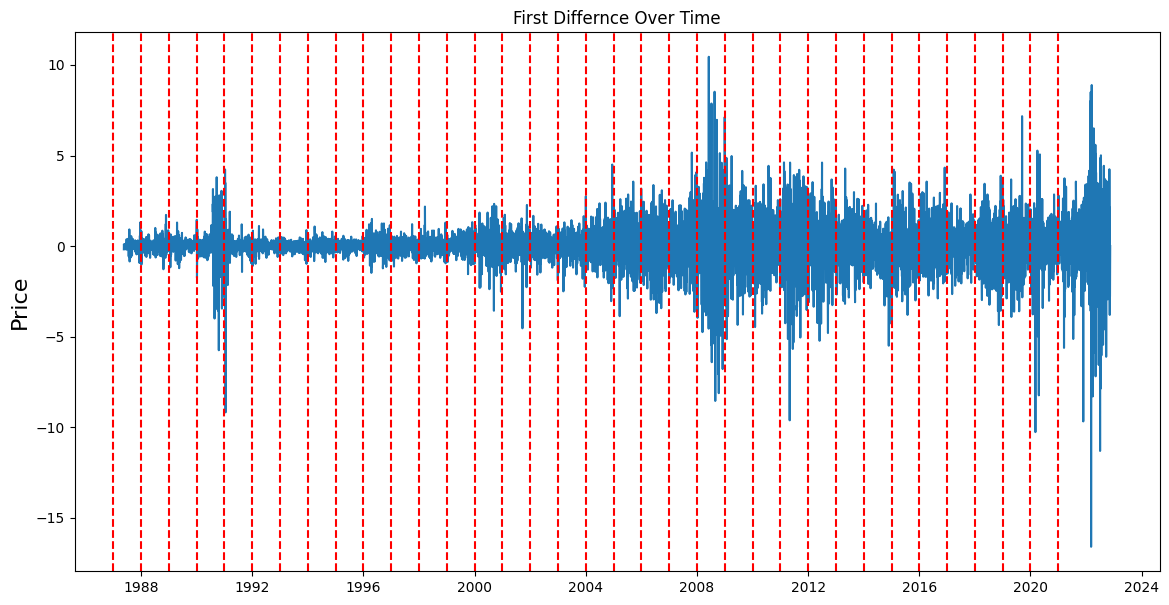

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(14,7))
plt.plot(brent_oil_price_data['FirstDifference'])
plt.title('First Differnce Over Time')
plt.ylabel("Price",fontsize=16)
for year in range(1987,2022):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'),color='r',linestyle='--')

In [19]:
result=check_stationarity(brent_oil_price_data['FirstDifference'])

ADF Statistic: -15.530212682509218
p-value: 2.22547285829734e-28
Critical Values: {'1%': -3.431078253154464, '5%': -2.8618618405570615, '10%': -2.5669413107032493}
Conclusion: Stationary


In [26]:
brent_oil_price_data.drop(columns=['Date','Price'])

,FirstDifference
Date,
1987-05-20,-0.18
1987-05-21,0.10
1987-05-22,0.05
1987-05-25,0.03
1987-05-26,-0.03
...,...
2022-11-08,-3.80
2022-11-09,1.20
2022-11-10,2.12


### Trai Test Split

In [32]:
import datetime
from datetime import timedelta
train_end='2018-05-20'
test_end='2022-11-13'

train_data=brent_oil_price_data[:train_end]['FirstDifference']
test_data=brent_oil_price_data['2018-05-21':test_end]['FirstDifference']

### Fit the model

In [33]:
import statsmodels.api as sm

# Fit the ARIMA model on the training data
p, d, q = 1, 1, 1  # Adjust based on your analysis
arima_model = sm.tsa.ARIMA(train_data.dropna(), order=(p, d, q))
arima_result = arima_model.fit()

g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


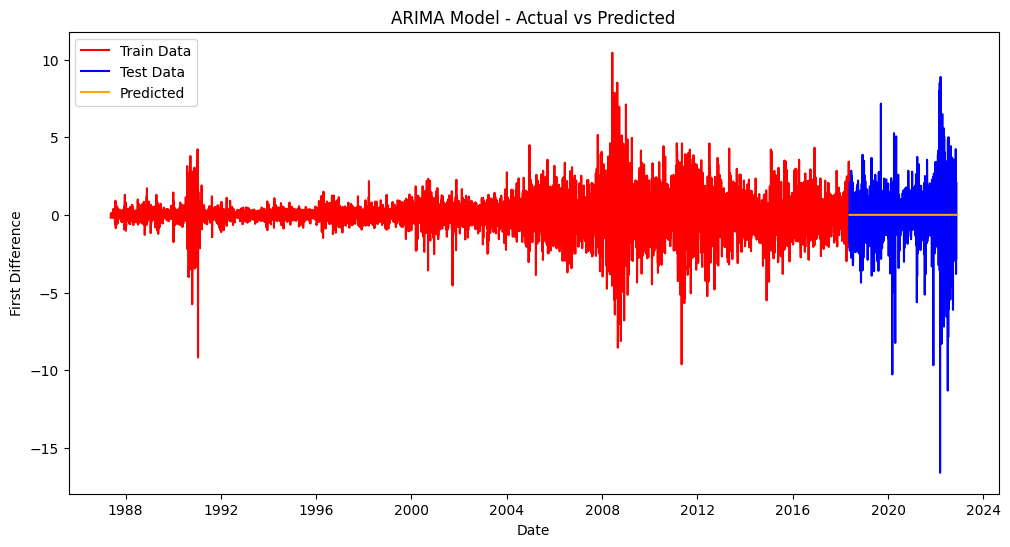

In [37]:
# Make predictions for the test period
predictions = arima_result.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, typ='levels')

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Train Data',color='red')
plt.plot(test_data.index, test_data, label='Test Data',color='blue')
plt.plot(test_data.index, predictions, label='Predicted', color='orange')
plt.title('ARIMA Model - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('First Difference')
plt.legend()
plt.show()

In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Convert both test_data and predictions to numeric, ensuring compatibility
test_data_clean = pd.to_numeric(test_data, errors='coerce').dropna()
predictions_clean = pd.to_numeric(predictions[:len(test_data_clean)], errors='coerce')

# Assuming predictions_clean has the same length as test_data_clean
predictions_clean.index = test_data_clean.index

# Recalculate MAE, MSE, RMSE as before
mae = mean_absolute_error(test_data_clean, predictions_clean)
mse = mean_squared_error(test_data_clean, predictions_clean)
rmse = np.sqrt(mse)

# Calculate MAPE, handling any zero values by replacing them with np.nan
mape = np.mean(np.abs((test_data_clean - predictions_clean) / test_data_clean.replace({0: np.nan}))) * 100

# Print results
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")



Mean Absolute Error (MAE): 1.323356365064233
Mean Squared Error (MSE): 3.93695871514432
Root Mean Squared Error (RMSE): 1.9841770876472493
Mean Absolute Percentage Error (MAPE): 99.75081200335718 %


In [53]:
brent_oil_price_data=pd.read_csv("data/brent_oil_price_data.csv")

In [54]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Assuming brent_oil_price_data is your original DataFrame and you've already created the 'FirstDifference' column.
# Ensure that you drop any NaN values that may have been generated during the differencing process.
brent_oil_price_data['FirstDifference'] = brent_oil_price_data['Price'].diff()

# Drop the NaN values after differencing
brent_oil_price_data = brent_oil_price_data.dropna()

# Split the data into train and test sets
train_end = '2018-05-20'
test_end = '2022-11-13'

train_data = brent_oil_price_data.loc[:train_end, 'FirstDifference']
test_data = brent_oil_price_data.loc['2018-05-21':test_end, 'FirstDifference']

# Fit the ARIMA model
model = ARIMA(train_data, order=(1, 1, 1))  # Specify your (p, d, q) values
fitted_model = model.fit()

# Make predictions
predictions = fitted_model.forecast(steps=len(test_data))

# Evaluate the model
# Convert predictions to a Series for easy calculation
predictions_series = pd.Series(predictions, index=test_data.index)

# Calculate evaluation metrics
mae = np.mean(np.abs(predictions_series - test_data))
mse = np.mean((predictions_series - test_data) ** 2)
rmse = np.sqrt(mse)
# Calculate MAPE, handling any zero values by replacing them with np.nan
mape = np.mean(np.abs((test_data - predictions_series) / test_data.replace({0: np.nan}))) * 100  # This might need handling for NaNs

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")


g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, f

Mean Absolute Error (MAE): 0.1529947397958963
Mean Squared Error (MSE): 0.035885606906133814
Root Mean Squared Error (RMSE): 0.1894349674852397
Mean Absolute Percentage Error (MAPE): 98.88204643482106 %


g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
g:\Programming\10_Academy\Week_10\Brent_Oil_Price_Changepont_Analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [57]:
brent_oil_price_data.set_index(brent_oil_price_data['Date'],inplace=True)

In [62]:
brent_oil_price_data

,Date,Price,FirstDifference
Date,,,
1987-05-21,1987-05-21,18.45,-0.18
1987-05-22,1987-05-22,18.55,0.10
1987-05-25,1987-05-25,18.60,0.05
1987-05-26,1987-05-26,18.63,0.03
1987-05-27,1987-05-27,18.60,-0.03
...,...,...,...
2022-11-08,2022-11-08,96.85,-3.02
2022-11-09,2022-11-09,93.05,-3.80
2022-11-10,2022-11-10,94.25,1.20


In [63]:
brent_oil_price_data['Price']['2018-05-21']
# brent_oil_price_data['Price'][4]

78.34

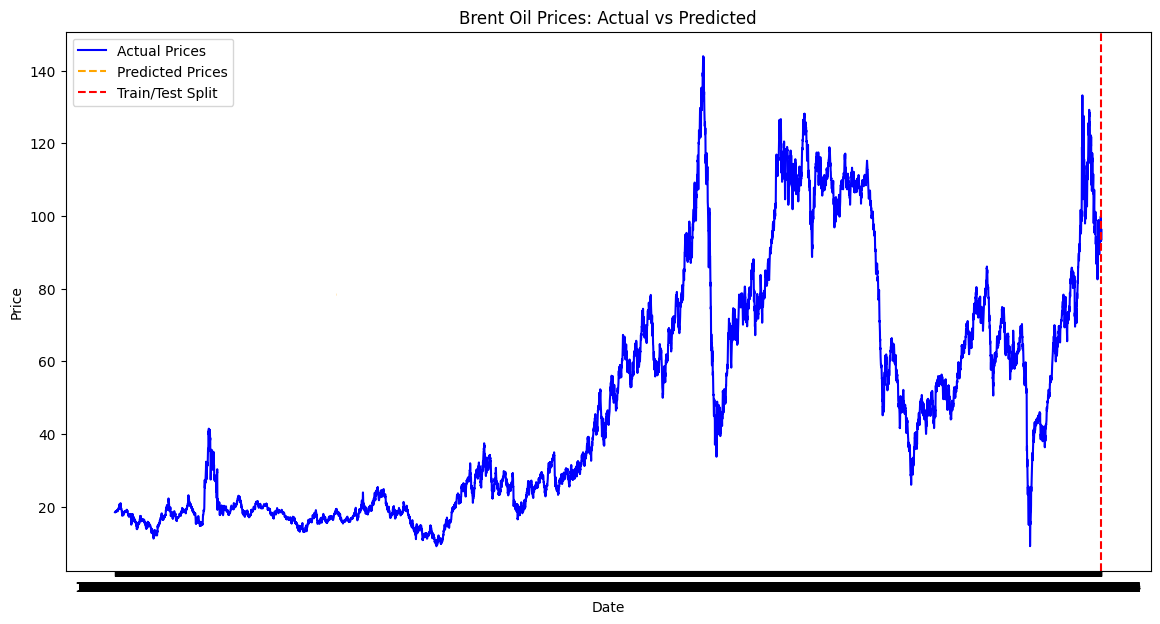

In [64]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'Price' is the original price column in your DataFrame

# Step 1: Calculate the predicted prices from the predictions
last_price = brent_oil_price_data.loc['2018-05-21', 'Price']  # Get the last known price from the training set

# Cumulative sum of the predictions to get actual predicted prices
predicted_prices = last_price + predictions_series.cumsum()

# Step 2: Plot the actual prices and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(brent_oil_price_data['Price'], label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='orange', linestyle='--')
plt.axvline(x=train_end, color='red', linestyle='--', label='Train/Test Split')
plt.title('Brent Oil Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


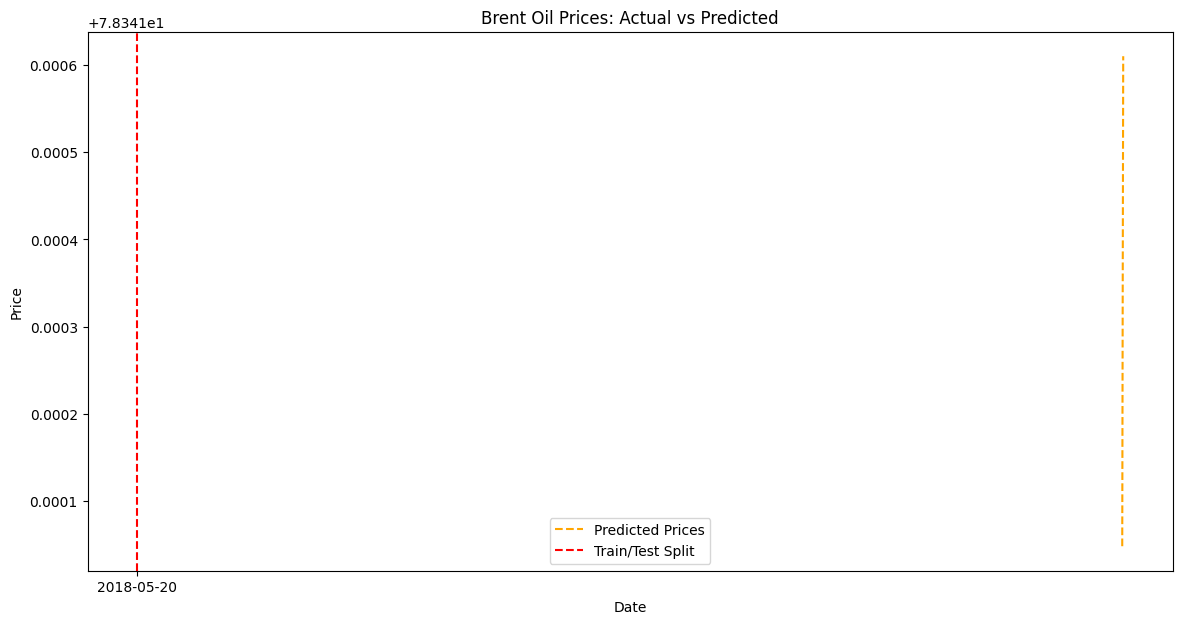

In [65]:
plt.figure(figsize=(14, 7))
# plt.plot(brent_oil_price_data['Price'], label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='orange', linestyle='--')
plt.axvline(x=train_end, color='red', linestyle='--', label='Train/Test Split')
plt.title('Brent Oil Prices: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()